# Simulación ATFE (Agitated Thin Film Evaporator) para Biodiésel y DBE

Este notebook simula la operación de un ATFE bajo vacío, con mezcla de **metanol + dimetil adipato (DBE) + biodiésel** (FAME), permitiendo comparar tipos de biodiésel (girasol vs. palma) y visualizar:

- Temperatura del líquido
- Viscosidad
- Fracciones másicas
- Coeficiente global U
- **Potencia acumulada del rotor**
- **Caudal evaporado por segmento**

Incluye un modo robusto (sin `thermo`) que **siempre dibuja** para diagnóstico rápido, y modo termodinámico riguroso si `thermo` está disponible.

In [11]:
# -*- coding: utf-8 -*-
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# ===== Utilidades de unidades =====
def bar_to_Pa(bar): 
    return bar * 1e5

def C_to_K(C):
    return C + 273.15

def K_to_C(K):
    return K - 273.15

# ===== Termodinámica (opcional con 'thermo') =====
try:
    from thermo import Mixture
    HAS_THERMO = True
    print("[INFO] Librería 'thermo' disponible: se usarán propiedades reales de mezcla.")
except Exception:
    HAS_THERMO = False
    print("[INFO] 'thermo' no disponible: se usará modo simplificado para garantizar que dibuje.")


[INFO] Librería 'thermo' disponible: se usarán propiedades reales de mezcla.


In [12]:
def _safe_normalize(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    if not np.isfinite(s) or s <= 0:
        # fallback razonable para 3 componentes
        return np.array([1.0, 0.0, 0.0])[:len(x)]
    return x / s

# Parámetros del ATFE (puedes ajustar aquí)
ATFE_PARAMS = {
    "L": 3.0,              # Longitud (m)
    "D": 0.5,              # Diámetro (m)
    "RPM": 300.0,          # Velocidad del rotor
    "film_thickness": 0.001, # Espesor de película (m)
    "P_op_bar": 0.05,      # 50 mbar (alto vacío)
    "T_wall_C": 180.0,     # Aceite térmico (°C)
    "U_ref": 1200.0,       # W/m2-K (promedio)
    "mu_ref": 0.0005,      # Pa·s (~0.5 cP)
    "exponent_n": 0.25,    # U ~ (mu_ref/mu)^n
    "N_steps": 50          # nodos
}

# Feed por defecto (mezcla con DBE)
FEED_DEFAULT = {
    "m_dot_kg_h": 500.0,             # kg/h
    "ws": [0.05, 0.45, 0.50],        # [MeOH, DBE, Biodiésel]
    "T_feed_C": 60.0
}

# Mapear tipos de biodiésel a un componente de FAME
def biodiesel_component(biodiesel_type='sunflower'):
    if biodiesel_type == 'sunflower':
        return 'methyl linoleate', "Girasol (Linoleico)"
    elif biodiesel_type == 'palm':
        return 'methyl palmitate', "Palma (Palmítico)"
    else:
        return 'methyl oleate', "Genérico (Oleico)"


In [13]:
def simular_atfe(biodiesel_type='sunflower', feed=FEED_DEFAULT, params=ATFE_PARAMS, debug=False):
    # --- Geometría y condiciones ---
    L = params["L"]; D = params["D"]
    Area_total = np.pi * D * L
    N_steps = params["N_steps"]
    dA = Area_total / max(N_steps, 1)

    RPM = params["RPM"]
    tip_speed = (RPM * np.pi * D) / 60.0
    film_th = max(params["film_thickness"], 1e-6)

    P_op_Pa = bar_to_Pa(params["P_op_bar"])
    T_wall_K = C_to_K(params["T_wall_C"])
    U_ref = params["U_ref"]; mu_ref = params["mu_ref"]; exponent_n = params["exponent_n"]

    # --- Componentes --- (metanol + DBE + biodiésel)
    bio_comp, label = biodiesel_component(biodiesel_type)
    comps = ['methanol', 'dimethyl adipate', bio_comp]

    # --- Feed ---
    m_dot_feed = feed["m_dot_kg_h"] / 3600.0  # kg/s
    ws_feed = feed["ws"]
    T_curr_K = C_to_K(feed["T_feed_C"])

    # Estado inicial
    m_comps = [m_dot_feed * w for w in ws_feed]

    # Resultados
    results = {
        'len': [], 'temp': [], 'visc': [], 'power_seg': [],
        'w_meoh': [], 'w_dbe': [], 'w_bio': [], 'U': [],
        'm_evap_seg': [], 'power_cum': []
    }
    cumulative_power = 0.0

    for i in range(N_steps):
        m_liq_total = sum(m_comps)
        if not np.isfinite(m_liq_total) or m_liq_total <= 1e-12:
            if debug: print(f"[DEBUG] liquido agotado en i={i}")
            break

        ws_curr = [m / m_liq_total for m in m_comps]
        ws_curr = _safe_normalize(ws_curr).tolist()

        # Respaldos (modo simplificado)
        mu_liq = mu_ref
        Tb_meoh = C_to_K(30)    # ~vacío
        Tb_dbe  = C_to_K(150)
        Tb_bio  = C_to_K(230)
        T_boil_K = ws_curr[0]*Tb_meoh + ws_curr[1]*Tb_dbe + ws_curr[2]*Tb_bio
        ws_vap = _safe_normalize([0.85, 0.15, 0.0])  # vapor rico en ligeros
        H_vap_mix = 6.0e5     # J/kg
        Cp_liq    = 2000.0    # J/kg-K

        # Intento con 'thermo' si está disponible
        if HAS_THERMO:
            try:
                mix = Mixture(comps, ws=ws_curr, T=T_curr_K, P=P_op_Pa)
                if getattr(mix, 'mul', None): mu_liq = mix.mul

                # Punto de burbuja a P_op
                try:
                    bp = mix.bubble_point_at_P(P_op_Pa)
                    if getattr(bp, 'T', None): T_boil_K = float(bp.T)
                except Exception as e:
                    if debug: print(f"[DEBUG] bubble_point fallo: {e}")

                # Flash para composición de vapor
                try:
                    phase_eq = mix.flash(P=P_op_Pa, T=T_boil_K)
                    ys_v = np.asarray(phase_eq.y, dtype=float)
                    MWs = np.asarray(mix.MWs, dtype=float)
                    MW_avg = float((ys_v * MWs).sum())
                    if MW_avg > 0 and np.isfinite(MW_avg):
                        ws_vap = _safe_normalize((ys_v * MWs) / MW_avg)
                except Exception as e:
                    if debug: print(f"[DEBUG] flash fallo: {e}")

                if getattr(mix, 'Hvapm', None) and getattr(mix, 'MW', None):
                    H_vap_mix = mix.Hvapm / (mix.MW / 1000.0)
                if getattr(mix, 'Cplm', None) and getattr(mix, 'MW', None):
                    Cp_liq = mix.Cplm / (mix.MW / 1000.0)
            except Exception as e:
                if debug: print(f"[DEBUG] fallo thermo en i={i}: {e}")

        # Sanitización
        if not np.isfinite(mu_liq) or mu_liq <= 1e-12: mu_liq = mu_ref
        if not np.isfinite(Cp_liq) or Cp_liq < 100.0:   Cp_liq = 2000.0
        if not np.isfinite(H_vap_mix) or H_vap_mix < 1e4: H_vap_mix = 6e5

        # Potencia mecánica del segmento (cizalla sobre área)
        shear_rate = (tip_speed**2) / film_th
        P_seg = mu_liq * dA * shear_rate   # W
        if not np.isfinite(P_seg): P_seg = 0.0
        cumulative_power += P_seg

        # U local vs viscosidad
        ratio = mu_ref / mu_liq if mu_liq > 1e-12 else 1.0
        U_local = float(np.clip(U_ref * (ratio ** exponent_n), 150.0, 2500.0))

        # Calor transferido
        Q_watts = U_local * dA * (T_wall_K - T_curr_K)
        if not np.isfinite(Q_watts): Q_watts = 0.0

        # Balances
        m_evap = 0.0
        if T_curr_K < T_boil_K - 1e-6:
            dT = Q_watts / max(m_liq_total * Cp_liq, 1e-9)
            dT = float(np.clip(dT, -50.0, 50.0))
            T_curr_K = float(np.clip(T_curr_K + dT, 200.0, 700.0))
            if T_curr_K > T_boil_K: T_curr_K = T_boil_K
        else:
            m_evap = Q_watts / max(H_vap_mix, 1.0)   # kg/s
            m_evap = float(np.clip(m_evap, 0.0, m_liq_total))
            ws_vap = _safe_normalize(ws_vap)
            # descargar por componente
            for k in range(len(comps)):
                m_comps[k] -= m_evap * ws_vap[k]
                if m_comps[k] < 0.0 or not np.isfinite(m_comps[k]):
                    m_comps[k] = 0.0

        # Guardar
        z = i * (L / max(N_steps, 1))
        results['len'].append(z)
        results['temp'].append(K_to_C(T_curr_K))
        results['visc'].append(mu_liq * 1000.0)      # cP
        results['power_seg'].append(P_seg)           # W
        results['w_meoh'].append(ws_curr[0])
        results['w_dbe'].append(ws_curr[1])
        results['w_bio'].append(ws_curr[2])
        results['U'].append(U_local)
        results['m_evap_seg'].append(m_evap)         # kg/s
        results['power_cum'].append(cumulative_power)

    return results, label, cumulative_power


In [14]:
def plot_resultados(results, label, potencia_total_kw=None):
    z = np.asarray(results['len'], dtype=float)

    # Depuración rápida
    print(f"[DEBUG] {label} -> puntos: {len(z)} | z_min={np.nanmin(z) if len(z)>0 else '—'} z_max={np.nanmax(z) if len(z)>0 else '—'}")
    for key in ['temp','visc','w_meoh','w_dbe','w_bio','U','m_evap_seg','power_cum','power_seg']:
        arr = np.asarray(results.get(key, []), dtype=float)
        print(f"[DEBUG] serie {key}: n={arr.size}, NaN={np.isnan(arr).sum()}, min={np.nanmin(arr) if arr.size else '—'}, max={np.nanmax(arr) if arr.size else '—'}")

    if len(z) < 2:
        print(f"[ADVERTENCIA] Solo {len(z)} puntos para {label}. El gráfico puede verse vacío.")

    plt.figure(figsize=(14, 10))
    mstyle = {'lw':2, 'marker':'o', 'markersize':3, 'alpha':0.9}

    # 1) Temperatura
    plt.subplot(3,2,1)
    plt.plot(z, results['temp'], 'r-', **mstyle)
    plt.title(f'Temperatura del líquido ({label})')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('T (°C)')
    plt.grid(True)

    # 2) Viscosidad
    plt.subplot(3,2,2)
    plt.plot(z, results['visc'], 'b-', **mstyle)
    plt.title('Viscosidad del líquido')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('μ (cP)')
    plt.grid(True)

    # 3) Fracciones másicas
    plt.subplot(3,2,3)
    plt.plot(z, results['w_meoh'], label='MeOH', **mstyle)
    plt.plot(z, results['w_dbe'],  label='DBE',  **mstyle)
    plt.plot(z, results['w_bio'],  label='Biodiésel', **mstyle)
    plt.title('Fracciones másicas en líquido')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('w (-)')
    plt.legend()
    plt.grid(True)

    # 4) Coeficiente global U
    plt.subplot(3,2,4)
    plt.plot(z, results['U'], 'g-', **mstyle)
    plt.title('Coeficiente global U')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('U (W/m²·K)')
    plt.grid(True)

    # 5) Potencia acumulada
    plt.subplot(3,2,5)
    power_cum_kw = np.asarray(results['power_cum'], dtype=float) / 1000.0
    plt.plot(z, power_cum_kw, 'm-', **mstyle)
    plt.title('Potencia acumulada del rotor')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('Potencia acumulada (kW)')
    plt.grid(True)

    # 6) Caudal evaporado por segmento
    plt.subplot(3,2,6)
    m_evap_seg = np.asarray(results['m_evap_seg'], dtype=float)
    width = (z[1]-z[0] if len(z)>1 else 0.05)
    plt.bar(z, m_evap_seg, width=width, color='#1f77b4', alpha=0.7, edgecolor='k')
    plt.title('Caudal evaporado por segmento')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('m_evap,seg (kg/s)')
    plt.grid(True, axis='y')

    plt.tight_layout()
    if potencia_total_kw is not None:
        plt.suptitle(f'ATFE – {label} | Potencia total rotor: {potencia_total_kw:.3f} kW', y=1.02, fontsize=13)
    plt.show()


Potencia Total Rotor (Girasol (Linoleico)): 0.176 kW
Potencia Total Rotor (Palma (Palmítico)): 0.171 kW
[DEBUG] Girasol (Linoleico) -> puntos: 50 | z_min=0.0 z_max=2.94
[DEBUG] serie temp: n=50, NaN=0, min=92.86929328678286, max=179.99861740005565
[DEBUG] serie visc: n=50, NaN=0, min=0.5891983186234098, max=0.9130887335364576
[DEBUG] serie w_meoh: n=50, NaN=0, min=0.05, max=0.05
[DEBUG] serie w_dbe: n=50, NaN=0, min=0.44999999999999996, max=0.44999999999999996
[DEBUG] serie w_bio: n=50, NaN=0, min=0.5, max=0.5
[DEBUG] serie U: n=50, NaN=0, min=1032.2752175592277, max=1151.7504017702774
[DEBUG] serie m_evap_seg: n=50, NaN=0, min=0.0, max=0.0
[DEBUG] serie power_cum: n=50, NaN=0, min=5.308402857317992, max=176.1167531206085
[DEBUG] serie power_seg: n=50, NaN=0, min=3.425408641275917, max=5.308402857317992


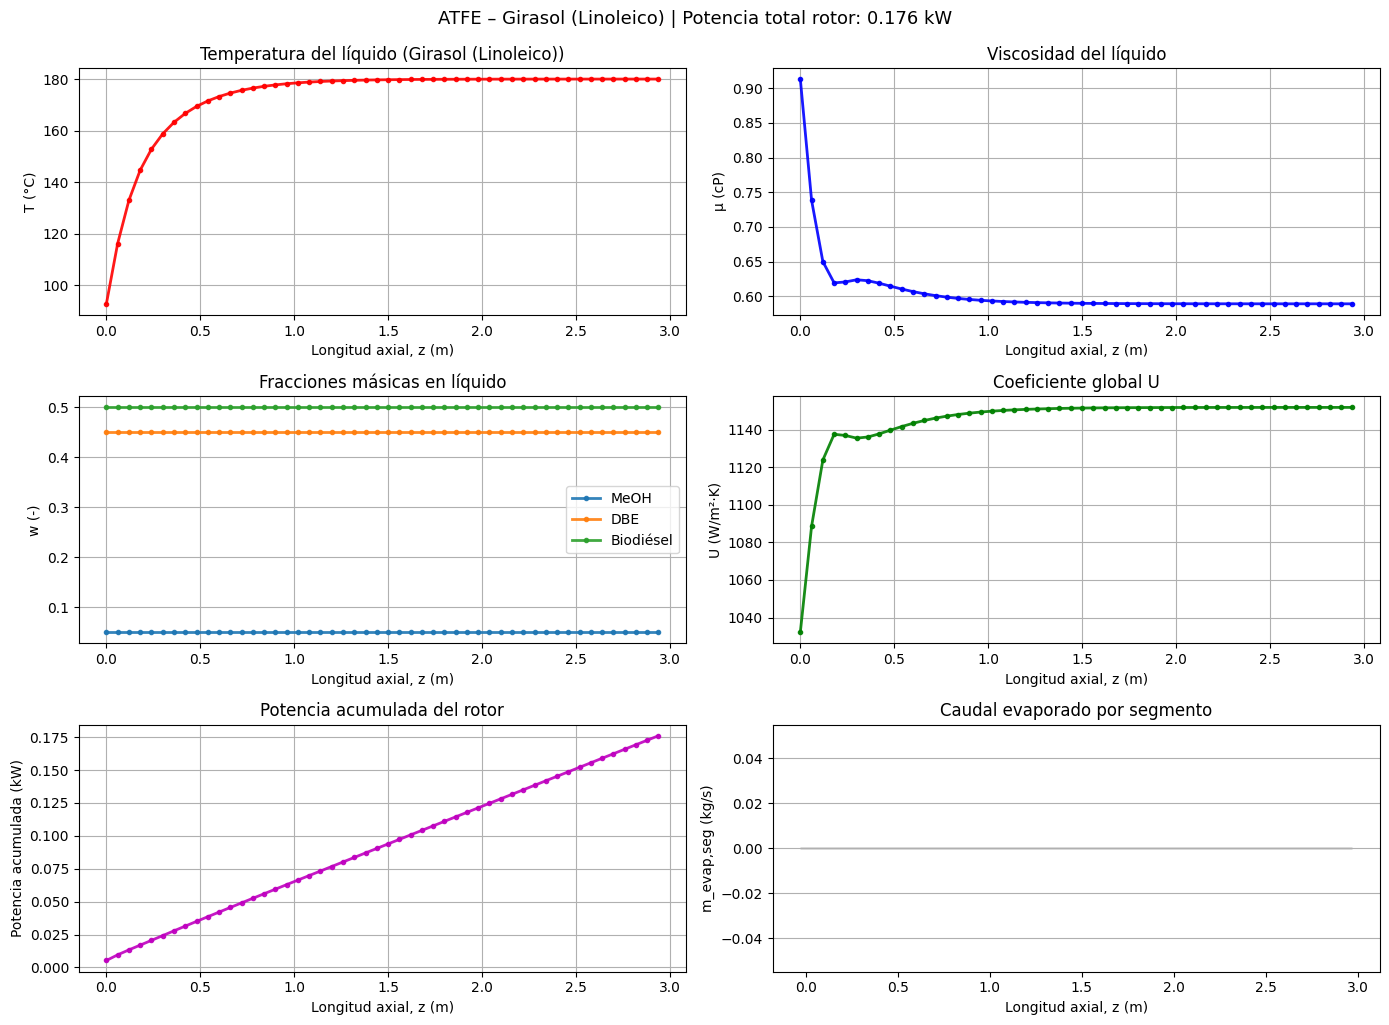

[DEBUG] Palma (Palmítico) -> puntos: 50 | z_min=0.0 z_max=2.94
[DEBUG] serie temp: n=50, NaN=0, min=93.40141404550388, max=179.9991246483853
[DEBUG] serie visc: n=50, NaN=0, min=0.5650620298098442, max=0.9770531122413444
[DEBUG] serie w_meoh: n=50, NaN=0, min=0.05, max=0.05
[DEBUG] serie w_dbe: n=50, NaN=0, min=0.44999999999999996, max=0.44999999999999996
[DEBUG] serie w_bio: n=50, NaN=0, min=0.5, max=0.5
[DEBUG] serie U: n=50, NaN=0, min=1014.94896263677, max=1163.857248800423
[DEBUG] serie m_evap_seg: n=50, NaN=0, min=0.0, max=0.0
[DEBUG] serie power_cum: n=50, NaN=0, min=5.680271086781841, max=170.64043955340958
[DEBUG] serie power_seg: n=50, NaN=0, min=3.2850880570904724, max=5.680271086781841


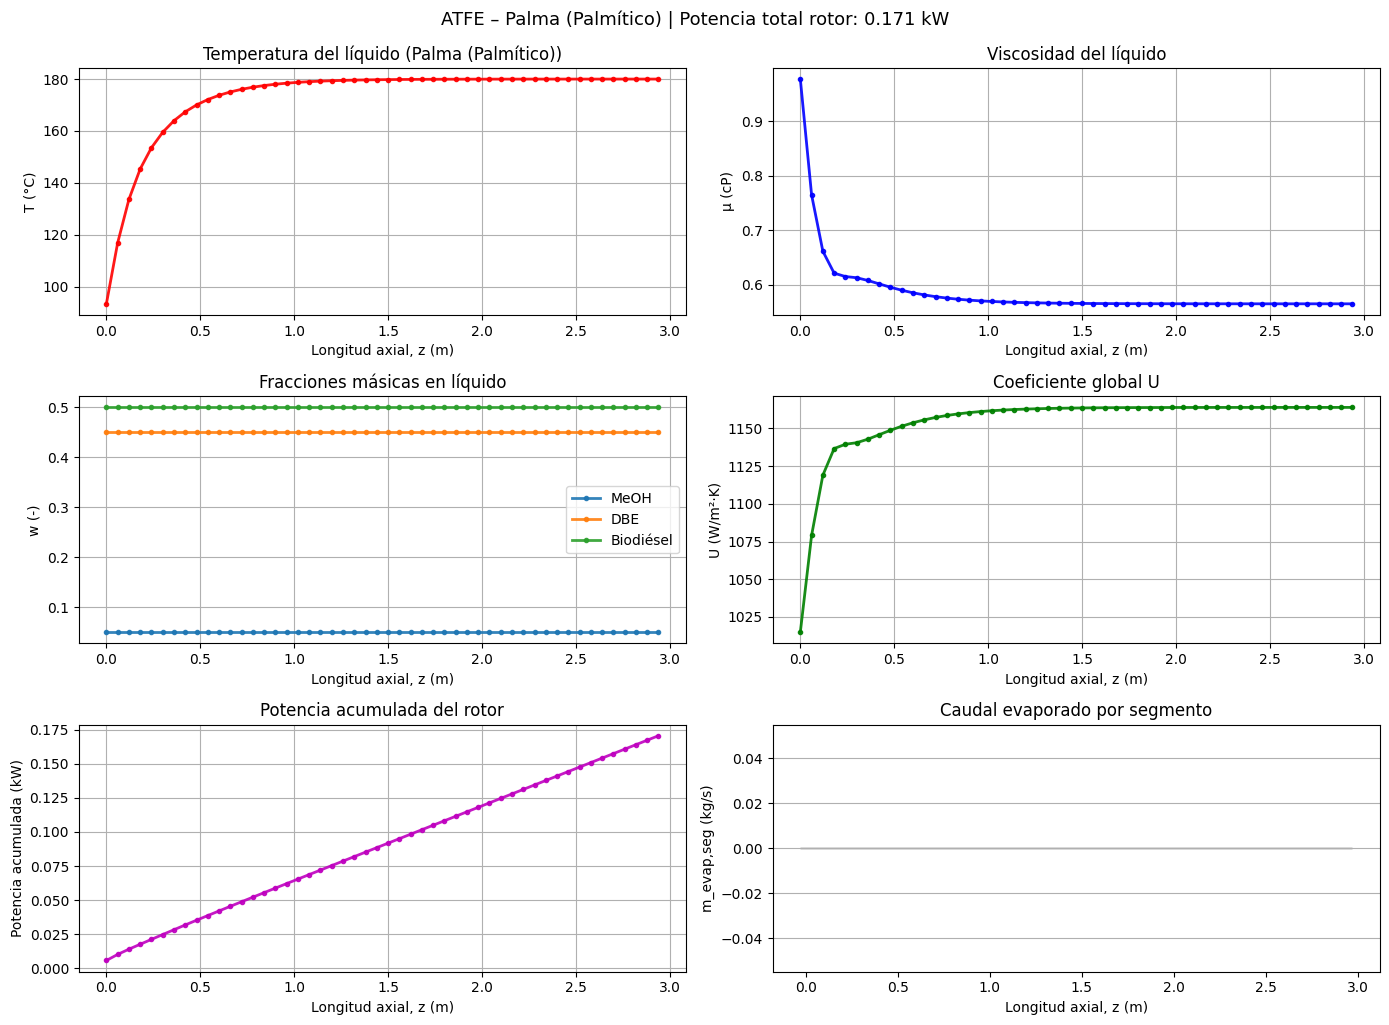

In [15]:
# Simular para biodiésel de girasol y de palma (misma alimentación con DBE + MeOH)
res_sun, label_sun, pow_sun_W = simular_atfe('sunflower', feed=FEED_DEFAULT, params=ATFE_PARAMS, debug=False)
res_palm, label_palm, pow_palm_W = simular_atfe('palm',      feed=FEED_DEFAULT, params=ATFE_PARAMS, debug=False)

print(f"Potencia Total Rotor ({label_sun}): {pow_sun_W/1000:.3f} kW")
print(f"Potencia Total Rotor ({label_palm}): {pow_palm_W/1000:.3f} kW")

plot_resultados(res_sun,  label_sun,  potencia_total_kw=pow_sun_W/1000.0)
plot_resultados(res_palm, label_palm, potencia_total_kw=pow_palm_W/1000.0)
